# Predict soccer player performance


## Motivation
The sports betting market is expected to reach $8 billion by 2025. Every participant believes he/she has a better sense of future than others. However, predicting match outcomes is challenging, especially at the individual player level, due to the nature of highly stochastic processes. Can we predict the performance of soccer players with machine learning techniques?


<img style="float: left;" src="https://www.telegraph.co.uk/content/dam/football/2018/04/04/TELEMMGLPICT000151290412_trans_NvBQzQNjv4BqUkPY_iHoT60TfDGz0jFsaLEu4odvKfIxFVccPQZWyAc.jpeg?imwidth=1400" width="700px"/>

## Data Collection

### Team Historical Performance
- Team evaluation (defense/offense) and match prediction (chance to win/draw/lose) from FiveThirtyEight.com
  - csv to SQL
- Sportsbook odds (odds to win/draw/lose, odds of total goals greater than 2)
  - csv to SQL

### Player Historical Performance
- Detailed performance (goals, assistants, passes, etc.)
  - webpage to SQL (Selenium)

### Data Management with Multiple Sources
    - Relational database (SQL)
    - Player name match

## Data Processing

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import numpy as np  
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# load existing PlayerList db
disk_engine = create_engine('sqlite:///EPL1718.db')
player_data_df = pd.read_sql('player_data_extended', disk_engine)
print(player_data_df.shape)

(9582, 80)


In [4]:
# first glance of all data
player_data_df.head(5)  

,team_name_full_roto,team_name_three_letter_DK,player_name_roto,player_name_DK_salary,game_date,opponent,is_away_game,form,is_starting,minutes,...,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,total_points,Position_DK
0,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-12-10,SOU,b'\x00',3421,1,90,...,0.25,2.27,2.19,1.75,1.71,4.20,3.80,1.93,-0.25,D
1,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-12-02,MUN,b'',3421,1,90,...,-0.25,2.14,2.10,1.85,1.80,2.32,3.43,3.36,0.25,D
2,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-11-29,HUD,b'',3421,1,90,...,-2.00,2.10,2.04,1.90,1.83,1.18,8.30,18.50,5.25,D
3,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-11-26,BUR,b'\x00',3421,1,90,...,1.00,1.95,1.90,2.03,1.97,6.25,4.20,1.61,6.00,D
4,Arsenal,ARS,Hector Bellerin,Hector Bellerin,2017-11-18,TOT,b'',3421,1,90,...,-0.25,2.19,2.11,1.83,1.78,2.49,3.50,3.00,2.75,D


### Target Variable: total_points
<img style="float: left;" src="https://dkstatic.s3.amazonaws.com/lp/2016-How-to-Play-FOT/Big-Time_Scoring.png" width="200px"/>


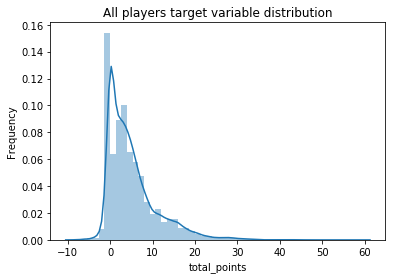

In [5]:
# take a look at the target variable original distribution
sns.distplot(player_data_df['total_points'])
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('All players target variable distribution')
plt.show()

### Remove Outliers

remove 2506 records that player not starting


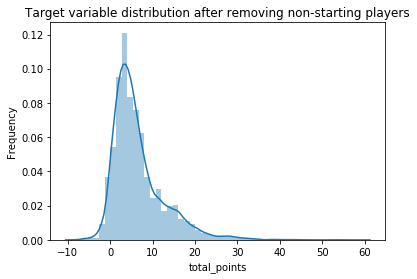

In [6]:
# remove players with not starting
print('remove', sum(player_data_df['is_starting'] != 1), 'records that player not starting')
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution after removing non-starting players')
sns.distplot(player_data_df[player_data_df['is_starting'] == 1]['total_points'])
plt.show()

remove 176 records that player early substitution


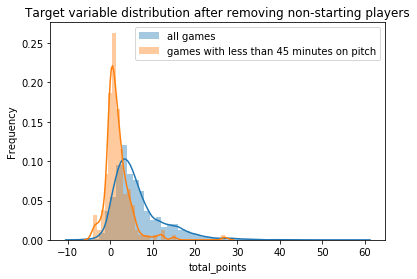

In [7]:
# remove outliers with early substitution (injury)
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution after removing non-starting players')
sns.distplot(player_data_df[player_data_df['is_starting'] == 1]['total_points'], label='all games')
print('remove', sum((player_data_df['minutes'] <= 45) & (player_data_df['is_starting'] == 1)),
      'records that player early substitution')
sns.distplot(player_data_df[(player_data_df['minutes'] <= 45) & (player_data_df['is_starting'] == 1)]['total_points'], label='games with less than 45 minutes on pitch');
plt.legend()
plt.show()

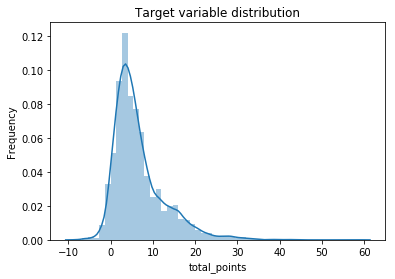

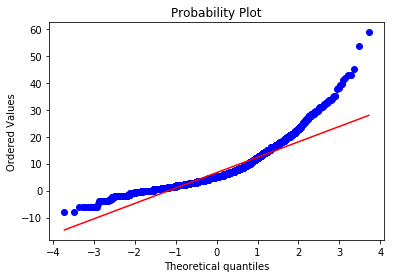

In [8]:
# How the target variable look like?
data_df = player_data_df.drop(
    player_data_df[(player_data_df['minutes'] <= 45) | (player_data_df['is_starting'] != 1)].index)
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution')
sns.distplot(data_df['total_points'], )  # fit=norm
plt.show()
fig = plt.figure()
res = stats.probplot(data_df['total_points'], plot=plt)  # Q-Q plot
plt.show()
# Skewed to the right

In [8]:
# Remove individual outliers
data_df.sort_values(by='total_points', ascending=False).head(10)

,team_name_full_roto,team_name_three_letter_DK,player_name_roto,player_name_DK_salary,game_date,opponent,is_away_game,form,is_starting,minutes,...,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,total_points,Position_DK
7299,Liverpool,LIV,Mohamed Salah,Mohamed Salah,2018-03-17,WAT,b'',433,1,90,...,-2.00,1.90,1.84,2.11,2.03,1.17,9.00,18.45,58.75,M/F
6287,Manchester City,MCI,Sergio Aguero,Sergio Aguero,2018-02-10,LEI,b'',433,1,90,...,-2.00,2.02,1.95,1.95,1.91,1.24,6.70,15.50,53.50,F
4282,Tottenham Hotspur,TOT,Harry Kane,Harry Kane,2017-12-23,BUR,b'\x00',4231,1,90,...,1.00,2.01,1.96,1.95,1.91,6.80,4.29,1.56,45.00,F
3116,Leicester City,LEI,Shinji Okazaki,Shinji Okazaki,2017-12-13,SOU,b'\x00',4231,1,90,...,-0.25,1.82,1.77,2.17,2.10,1.94,3.49,4.56,43.00,M/F
5389,Manchester City,MCI,Sergio Aguero,Sergio Aguero,2018-01-20,NEW,b'',433,1,90,...,-2.50,2.05,2.00,1.92,1.86,1.12,11.00,28.50,42.75,F
4281,Tottenham Hotspur,TOT,Harry Kane,Harry Kane,2017-12-26,SOU,b'',4231,1,90,...,-1.50,2.11,2.06,1.85,1.82,1.33,5.80,10.20,41.75,F
1868,Chelsea,CHE,Eden Hazard,Eden Hazard,2017-12-02,NEW,b'',3511,1,78,...,-1.75,2.05,2.00,1.95,1.88,1.24,6.65,16.50,41.00,M/F
1440,AFC Bournemouth,BOU,Callum Wilson,Callum Wilson,2017-11-18,HUD,b'',4411,1,90,...,-0.50,1.86,1.82,2.11,2.07,1.81,3.66,5.16,39.50,F
5557,Everton,EVE,Theo Walcott,Theo Walcott,2018-01-31,LEI,b'',4231,1,90,...,0.25,1.79,1.74,2.21,2.15,2.78,3.16,2.90,39.25,M/F
5933,Arsenal,ARS,Aaron Ramsey,Aaron Ramsey,2018-02-03,EVE,b'',4231,1,75,...,-1.75,2.18,2.11,1.81,1.77,1.37,5.45,9.50,38.00,M


In [9]:
data_df.sort_values(by='total_points', ascending=True).head(10)

,team_name_full_roto,team_name_three_letter_DK,player_name_roto,player_name_DK_salary,game_date,opponent,is_away_game,form,is_starting,minutes,...,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,total_points,Position_DK
3903,Southampton,SOU,Fraser Forster,Fraser Forster,2017-12-26,TOT,b'\x00',4141,1,90,...,-1.50,2.11,2.06,1.85,1.82,1.33,5.80,10.20,-8.0,GK
442,Huddersfield Town,HUD,Jonas Lossl,Jonas Lossl,2017-11-29,ARS,b'\x00',3421,1,90,...,-2.00,2.10,2.04,1.90,1.83,1.18,8.30,18.50,-8.0,GK
2186,Brighton & Hove Albion,BHA,Mathew Ryan,Mat Ryan,2017-12-02,LIV,b'',4411,1,90,...,1.00,2.13,2.09,1.84,1.80,7.25,4.39,1.53,-6.0,GK
2597,Liverpool,LIV,Simon Mignolet,Simon Mignolet,2017-10-22,TOT,b'\x00',433,1,90,...,-0.25,1.93,1.88,2.03,1.99,2.24,3.62,3.36,-6.0,GK
3792,AFC Bournemouth,BOU,Asmir Begovic,Asmir Begovic,2017-12-23,MCI,b'\x00',3421,1,90,...,-2.75,2.01,1.93,1.99,1.94,1.09,15.00,27.00,-6.0,GK
5069,Huddersfield Town,HUD,Jonas Lossl,Jonas Lossl,2018-01-13,WHU,b'',4231,1,90,...,-0.25,2.32,2.22,1.73,1.70,2.94,3.11,2.79,-6.0,GK
444,Huddersfield Town,HUD,Jonas Lossl,Jonas Lossl,2017-11-18,BOU,b'\x00',4231,1,90,...,-0.50,1.86,1.82,2.11,2.07,1.81,3.66,5.16,-6.0,GK
6341,AFC Bournemouth,BOU,Asmir Begovic,Asmir Begovic,2018-02-11,HUD,b'\x00',3421,1,90,...,0.25,1.88,1.83,2.09,2.03,3.14,3.39,2.45,-6.0,GK
6217,Swansea City,SWA,Lukasz Fabianski,Lukasz Fabianski,2018-02-24,BHA,b'\x00',541,1,90,...,-0.25,1.80,1.77,2.19,2.11,2.01,3.31,4.53,-6.0,GK
207,Everton,EVE,Jordan Pickford,Jordan Pickford,2017-11-26,SOU,b'\x00',442,1,90,...,-0.75,2.20,2.15,1.82,1.75,1.81,3.72,5.00,-6.0,GK


In [9]:
# Remove individual outliers
data_df = data_df.sort_values(by='total_points', ascending=False).iloc[2:]  # drop the highest two games
data_df = data_df.sort_values(by='total_points', ascending=True).iloc[2:]  # drop the lowest two games
print('after removing outliers, remaining games:', len(data_df))

after removing outliers, remaining games: 6896


### Data Transformation

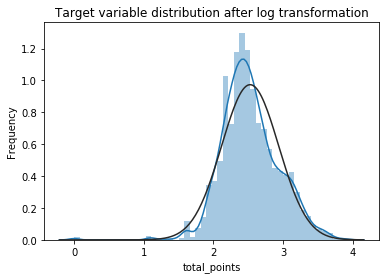

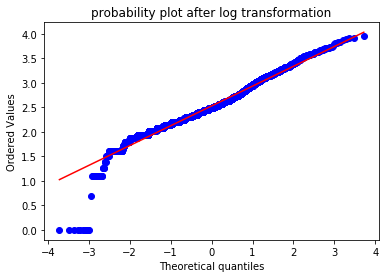

data size after pre-processing (6896, 80)


In [10]:
# fix skewness of the target variable
min_points_in_original_db = data_df['total_points'].min()
data_df['total_points'] = data_df['total_points'] - min_points_in_original_db
data_df['total_points'] = np.log1p(data_df['total_points'])
plt.figure()
plt.xlabel('total_points')
plt.ylabel('Frequency')
plt.title('Target variable distribution after log transformation')
sns.distplot(data_df['total_points'], fit=norm)
plt.show()
fig = plt.figure()
res = stats.probplot(data_df['total_points'], plot=plt)  # Q-Q plot
plt.title('probability plot after log transformation')
plt.show()
print('data size after pre-processing', data_df.shape)

### Missing Data

In [11]:
# Missing data
data_missing_percent = (data_df.isnull().sum() / len(data_df)) * 100
data_missing_percent = data_missing_percent.drop(data_missing_percent[data_missing_percent == 0].index).sort_values(
    ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': data_missing_percent})
print(missing_data)

             Missing Ratio
FPTSPerGame      26.783643


In [12]:
# impute missing FPTSPerGame with average of previous FPTSPerGame
# data_df['FPTSPerGame'] = data_df['FPTSPerGame'].fillna(data_df[~data_df['FPTSPerGame'].isnull()]['FPTSPerGame'].median())
# Impute with median of available FPTSPerGame seems not appropriate
    # missing data caused by missing DraftKings salary failes for certain 
index_with_no_previous_FPTSPerGame = []
for index in data_df[data_df['FPTSPerGame'].isnull()].index:
    try:  # impute with the FPTSPerGame that was available on the most recent day
        data_df.loc[index, 'FPTSPerGame'] = data_df[(data_df['game_date'] < data_df['game_date'][index])
                                                & (data_df['player_name_roto'] == data_df['player_name_roto'][index])
                                                & (~data_df['FPTSPerGame'].isnull())].sort_values('game_date',
                                                                                                  ascending=False) \
            ['FPTSPerGame'].iloc[0]
    except IndexError:  # if no FPTSPerGame available before the game day -- remove game data
        index_with_no_previous_FPTSPerGame.append(index)
data_df = data_df.drop(index_with_no_previous_FPTSPerGame)
print('drop another', len(index_with_no_previous_FPTSPerGame),
      'with no previous FPTSPerGame available for impute, remaining:', data_df.shape)

drop another 328 with no previous FPTSPerGame available for impute, remaining: (6568, 80)


In [13]:
# Double check missing data
data_missing_percent = (data_df.isnull().sum() / len(data_df)) * 100
data_missing_percent = data_missing_percent.drop(data_missing_percent[data_missing_percent == 0].index).sort_values(
    ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': data_missing_percent})
print(missing_data)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


### Data Leakage

In [14]:
# remove team and player information, since first build a general model
player_name_DK_salary_df = data_df['player_name_DK_salary'] # save 'player_name_DK_salary' seperately for testing purpose
data_df = data_df.drop(
    columns=['team_name_full_roto', 'team_name_three_letter_DK', 'player_name_roto', 'opponent', 'player_name_DK_salary']) 

# remove is_starting since all players are starting
data_df = data_df.drop(columns=['is_starting'])

# remove minutes to prevent data leakage, since we do not know how long player will be playing before game
data_df = data_df.drop(columns=['minutes'])

### Skewed Features

In [15]:
# Check the skewness of all numerical variables
numeric_variables = data_df.dtypes[(data_df.dtypes != 'object') & (data_df.dtypes != 'datetime64[ns]')].index
skewed_variables = data_df[numeric_variables].apply(lambda x: skew(x)).abs().sort_values(ascending=False)
print("Top 10 absolute skewness in numerical variables: ")
skewness = pd.DataFrame({'Skew': skewed_variables})
print(skewness.head(10))
lam = 0.1
for variable_name in skewness[(skewness['Skew'] > 3)].index:  # fix the skew variables with Box Cox Transformation
    data_df[variable_name] = boxcox1p(data_df[variable_name], lam)

Top 10 absolute skewness in numerical variables: 
                         Skew
Win_League_per       4.236426
oppo_Win_League_per  4.138678
LBH                  2.571946
BbMxH                2.505272
VCH                  2.480507
B365H                2.412006
WHH                  2.394795
BbAvH                2.351163
PSCD                 2.301080
PSH                  2.294022


### Transform home/away team win to player team win/lose

In [16]:
data_df_org = data_df.copy()  # Just a backup

In [92]:
data_df = data_df_org.copy()

In [17]:
# transform is_away_game from string to 0/1
data_df.loc[[ii == b'' for ii in data_df['is_away_game']], 'is_away_game'] = 0
data_df.loc[[ii == b'\x00' for ii in data_df['is_away_game']], 'is_away_game'] = 1
data_df = data_df.astype({'is_away_game': 'int'})

# Apply home/away game on 538 probabilities
data_df.loc[data_df['is_away_game']==0, '538_Prob_win'] = data_df.loc[data_df['is_away_game']==0, 'home_team_win_pred']
data_df.loc[data_df['is_away_game']==1, '538_Prob_win'] = data_df.loc[data_df['is_away_game']==1, 'Away_team_win_pred']
data_df['538_Prob_draw'] = data_df['draw_pred']
data_df.loc[data_df['is_away_game']==0, '538_Prob_lose'] = data_df.loc[data_df['is_away_game']==0, 'Away_team_win_pred']
data_df.loc[data_df['is_away_game']==1, '538_Prob_lose'] = data_df.loc[data_df['is_away_game']==1, 'home_team_win_pred']

# Apply home/away game on sportsbooks odds
home_odds = [i for i in data_df.columns if i[len(i)-1:] in 'H']
home_odds = [e for e in home_odds if e not in  ['pre_D', 'oppo_pre_D', 'BbAH', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA']]
draw_odds = [i for i in data_df.columns if i[len(i)-1:] in 'D']
draw_odds = [e for e in draw_odds if e not in  ['pre_D', 'oppo_pre_D', 'BbAH', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA']]
away_odds = [i for i in data_df.columns if i[len(i)-1:] in 'A']
away_odds = [e for e in away_odds if e not in  ['pre_D', 'oppo_pre_D', 'BbAH', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA']]
win_odds = [odd[:len(odd)-1] + '_win' for odd in home_odds]
draw_odds_new = [odd[:len(odd)-1] + '_draw' for odd in home_odds]
lose_odds = [odd[:len(odd)-1] + '_lose' for odd in home_odds]
data_df = pd.concat([data_df,pd.DataFrame(columns=win_odds+draw_odds_new+lose_odds)])

data_df.loc[data_df['is_away_game']==0, win_odds] = data_df.loc[data_df['is_away_game']==0, home_odds].values
data_df.loc[data_df['is_away_game']==1, win_odds] = data_df.loc[data_df['is_away_game']==1, away_odds].values
data_df[draw_odds_new] = data_df[draw_odds]
data_df.loc[data_df['is_away_game']==0, lose_odds] = data_df.loc[data_df['is_away_game']==0, away_odds].values
data_df.loc[data_df['is_away_game']==1, lose_odds] = data_df.loc[data_df['is_away_game']==1, home_odds].values
data_df = data_df.astype({element: 'float' for element in win_odds+draw_odds_new+lose_odds})

# Convert sportsbooks odds to probabilities
data_df['IW_Prob_win'] =  1/data_df['IW_win'] / (1/data_df['IW_win'] + 1/data_df['IW_draw'] + 1/data_df['IW_lose'])
data_df['IW_Prob_draw'] =  1/data_df['IW_draw'] / (1/data_df['IW_win'] + 1/data_df['IW_draw'] + 1/data_df['IW_lose'])
data_df['IW_Prob_lose'] =  1/data_df['IW_lose'] / (1/data_df['IW_win'] + 1/data_df['IW_draw'] + 1/data_df['IW_lose'])
data_df['PSC_Prob_win'] =  1/data_df['PSC_win'] / (1/data_df['PSC_win'] + 1/data_df['PSC_draw'] + 1/data_df['PSC_lose'])
data_df['PSC_Prob_draw'] =  1/data_df['PSC_draw'] / (1/data_df['PSC_win'] + 1/data_df['PSC_draw'] + 1/data_df['PSC_lose'])
data_df['PSC_Prob_lose'] =  1/data_df['PSC_lose'] / (1/data_df['PSC_win'] + 1/data_df['PSC_draw'] + 1/data_df['PSC_lose'])

# Drop Asian handicap odds
data_df.drop(['BbAH', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA'], axis=1, inplace=True)

# Move total points to the top of the front of the table
cols = list(data_df)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('total_points')))
data_df = data_df.loc[:, cols]

### Categorical Variable Encoding

In [18]:
# One-hot encoding for categorical data
data_df_before_encoding = data_df.copy()
data_df = pd.get_dummies(data_df)
print('all data shape:', data_df.shape)


all data shape: (6568, 146)


### Data Correlation

In [103]:
# Calculate the corrcoef maxtrix and p-values
from scipy.stats import pearsonr
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
corrmat_p = data_df.corr(method=pearsonr_pval)
corrmat = data_df.corr()


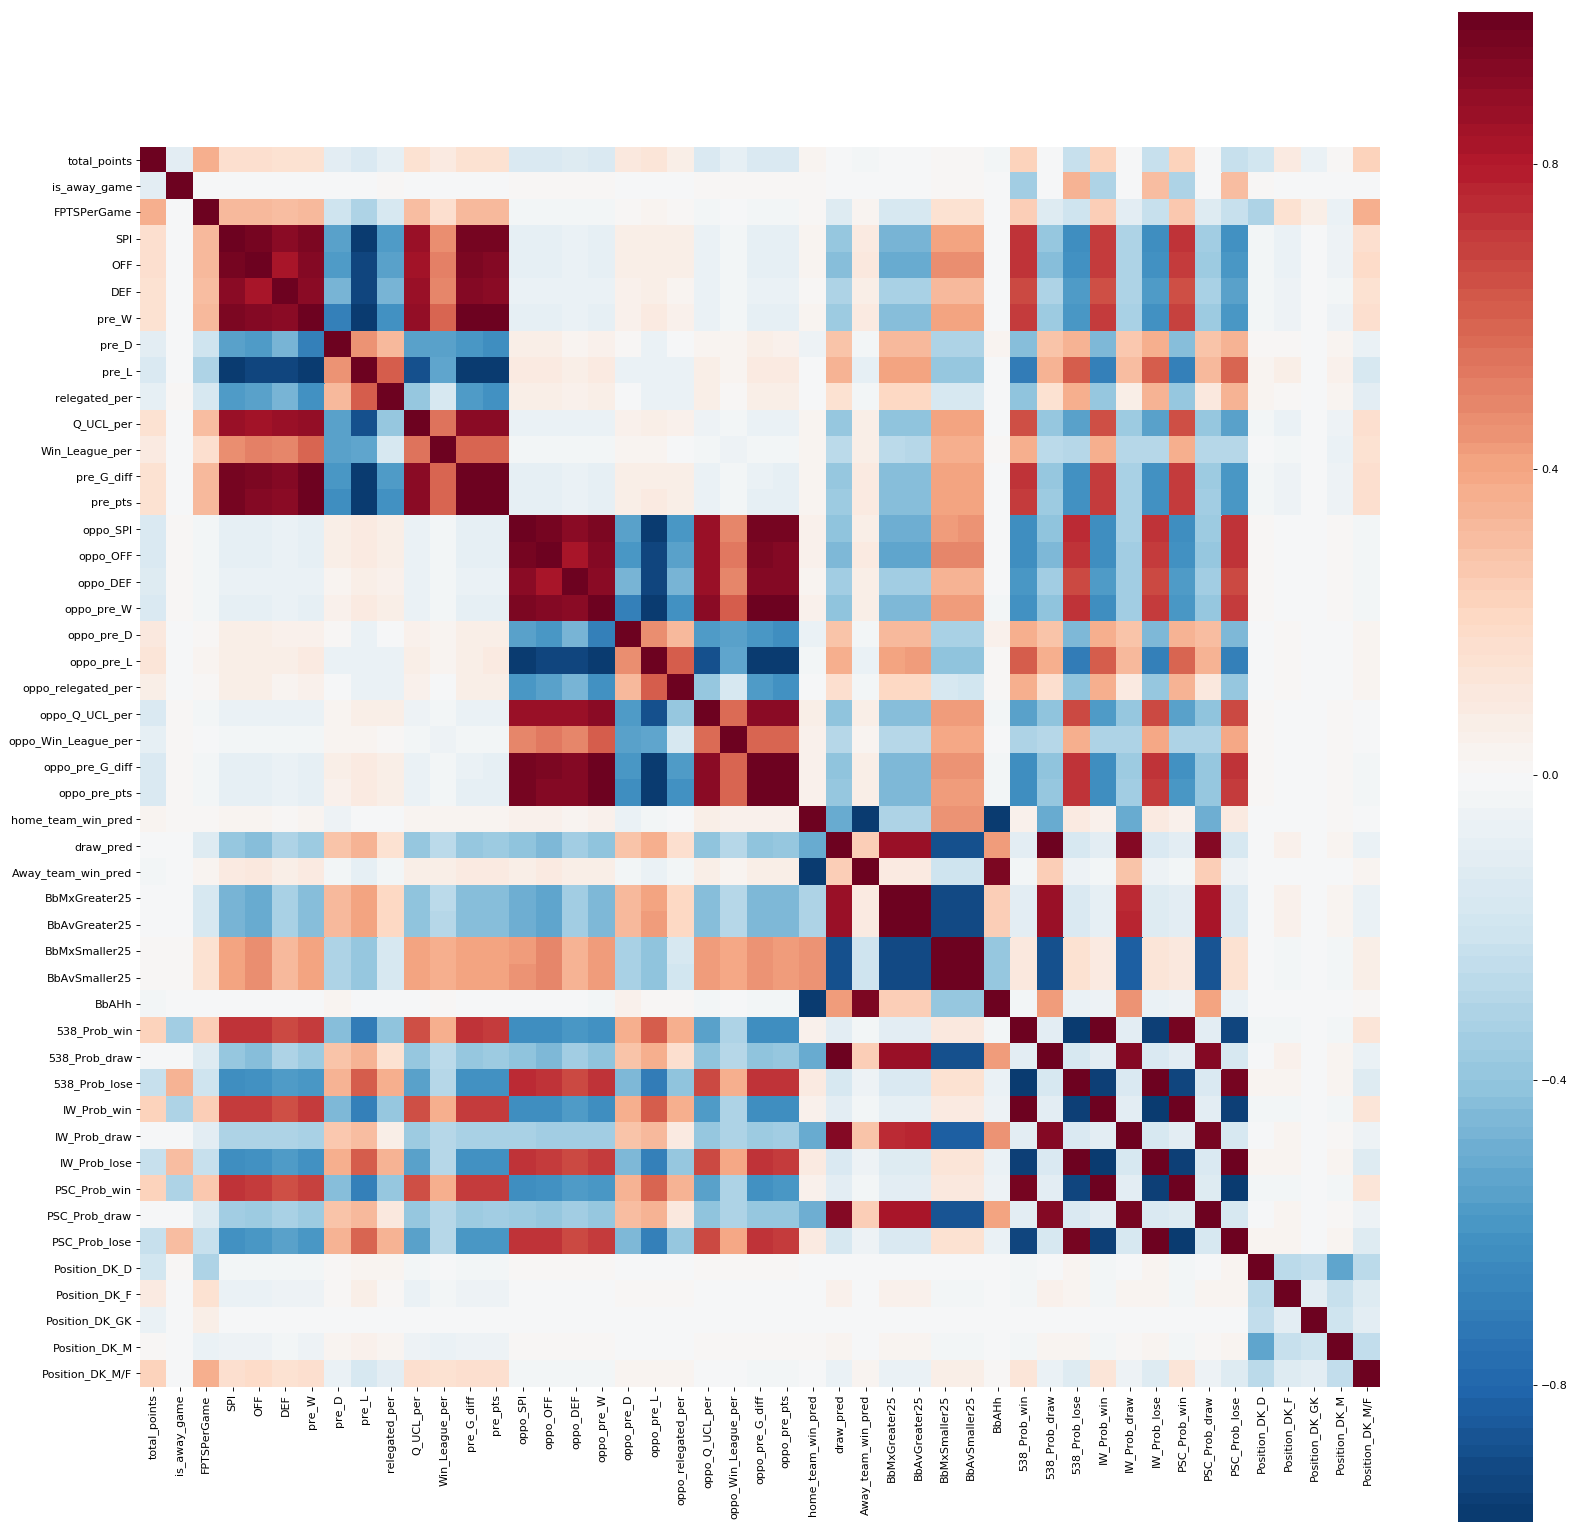

In [104]:
# data correlation
fig=plt.figure(figsize=(25,25), dpi= 80)
sns.heatmap(corrmat, square=True, xticklabels=True, yticklabels=True, center=0, cmap=sns.color_palette("RdBu_r", 100))
plt.show()


In [105]:
# First 15 features with highest abs corrcoef
total_points_corr_df = corrmat.loc[abs(corrmat.total_points).sort_values(ascending=False).head(15).index, 'total_points'].to_frame()
total_points_corr_df['p_value']  = \
    corrmat_p.loc[abs(corrmat.total_points).sort_values(ascending=False).head(15).index, 'total_points'].values
total_points_corr_df

,total_points,p_value
total_points,1.000000,1.000000e+00
FPTSPerGame,0.359483,1.392799e-199
Position_DK_M/F,0.235483,1.906335e-83
538_Prob_win,0.233242,7.395607e-82
PSC_Prob_win,0.231017,2.690238e-80
IW_Prob_win,0.230159,1.065328e-79
538_Prob_lose,-0.228850,8.591384e-79
PSC_Prob_lose,-0.227866,4.095498e-78
IW_Prob_lose,-0.227389,8.706666e-78
Position_DK_D,-0.186477,1.813874e-52


In [106]:
# Last 10 features with highest abs corrcoef
total_points_corr_df = corrmat.loc[abs(corrmat.total_points).sort_values(ascending=False).tail(10).index, 'total_points'].to_frame()
total_points_corr_df['p_value']  = \
    corrmat_p.loc[abs(corrmat.total_points).sort_values(ascending=False).tail(10).index, 'total_points'].values
total_points_corr_df

,total_points,p_value
BbAHh,-0.025666,0.037528
BbAvGreater25,-0.012701,0.303379
Position_DK_M,0.012635,0.305935
BbMxGreater25,-0.012588,0.307729
draw_pred,-0.010353,0.401523
538_Prob_draw,-0.010353,0.401523
BbAvSmaller25,0.010223,0.407449
BbMxSmaller25,0.009106,0.460583
PSC_Prob_draw,-0.005509,0.655326
IW_Prob_draw,-0.004218,0.732518


In [23]:
# Which sportbookers is more reliable for prediction? 
Ref_vs_Points_df = corrmat.loc[ [i for i in data_df.columns if i[len(i)-3:] in '_win'] \
                               + [i for i in data_df.columns if i[len(i)-4:] in '_draw']
                               + [i for i in data_df.columns if i[len(i)-4:] in '_lose'], \
                         ['total_points'] ]
# type(Ref_vs_Points_df)
Ref_vs_Points_df['p_value']=corrmat_p.loc[ [i for i in data_df.columns if i[len(i)-3:] in '_win'] \
                               + [i for i in data_df.columns if i[len(i)-4:] in '_draw' ] \
                               + [i for i in data_df.columns if i[len(i)-4:] in '_lose'], \
                         ['total_points'] ]
Ref_vs_Points_df

,total_points,p_value
538_Prob_win,0.233242,7.395607e-82
B365_win,-0.183889,4.779125e-51
BW_win,-0.186598,1.554299e-52
IW_win,-0.188968,7.419223e-54
LB_win,-0.181329,1.161003e-49
PS_win,-0.188902,8.077264e-54
WH_win,-0.186247,2.428517e-52
VC_win,-0.188506,1.347443e-53
BbMx_win,-0.182859,1.735764e-50
BbAv_win,-0.187833,3.199851e-53


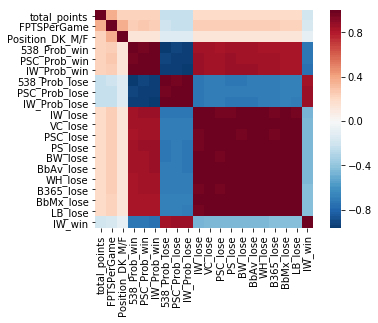

In [80]:
top_n_abs_corr_name = abs(corrmat.total_points).sort_values(ascending=False).head(20).index
sns.heatmap(corrmat.loc[top_n_abs_corr_name, top_n_abs_corr_name], square=True, xticklabels=True, yticklabels=True, \
            center=0, cmap=sns.color_palette("RdBu_r", 100))
plt.show()

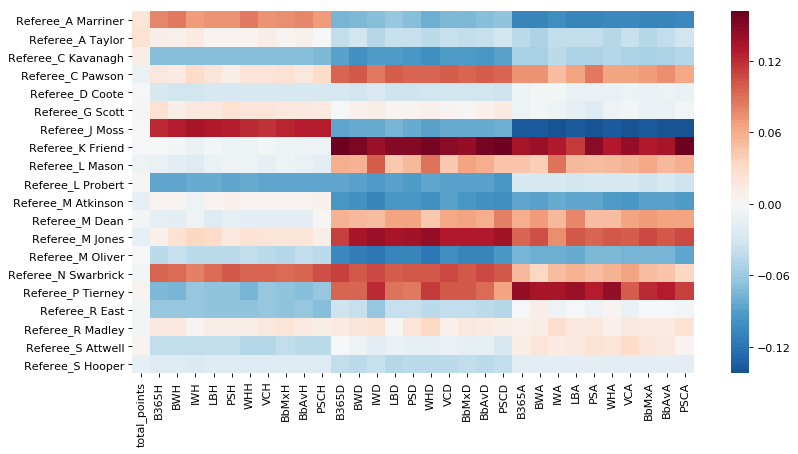

In [25]:
# Is referee easily influenced by the crowd
fig=plt.figure(figsize=(12,6), dpi= 80)
sns.heatmap(corrmat.loc[\
                        [i for i in data_df.columns if i[0:3]=='Ref'], \
                         ['total_points'] + home_odds+draw_odds+away_odds  ],\
                        square=True, xticklabels=True, yticklabels=True, \
            center=0, cmap=sns.color_palette("RdBu_r", 100))
plt.show()

In [26]:
# Referee 
Ref_vs_Points_df = corrmat.loc[ [i for i in data_df.columns if i[0:3]=='Ref'], \
                         ['PSCH'] ]
# type(Ref_vs_Points_df)
Ref_vs_Points_df['p_value']=corrmat_p.loc[ [i for i in data_df.columns if i[0:3]=='Ref'], \
                         ['PSCH'] ]
Ref_vs_Points_df

,PSCH,p_value
Referee_A Marriner,0.068753,2.440352e-08
Referee_A Taylor,0.000376,9.756934e-01
Referee_C Kavanagh,-0.072559,3.931014e-09
Referee_C Pawson,0.030505,1.342476e-02
Referee_D Coote,-0.027366,2.656449e-02
Referee_G Scott,0.014813,2.300230e-01
Referee_J Moss,0.128238,1.734973e-25
Referee_K Friend,-0.009459,4.434188e-01
Referee_L Mason,-0.018430,1.353225e-01
Referee_L Probert,-0.084080,8.796592e-12


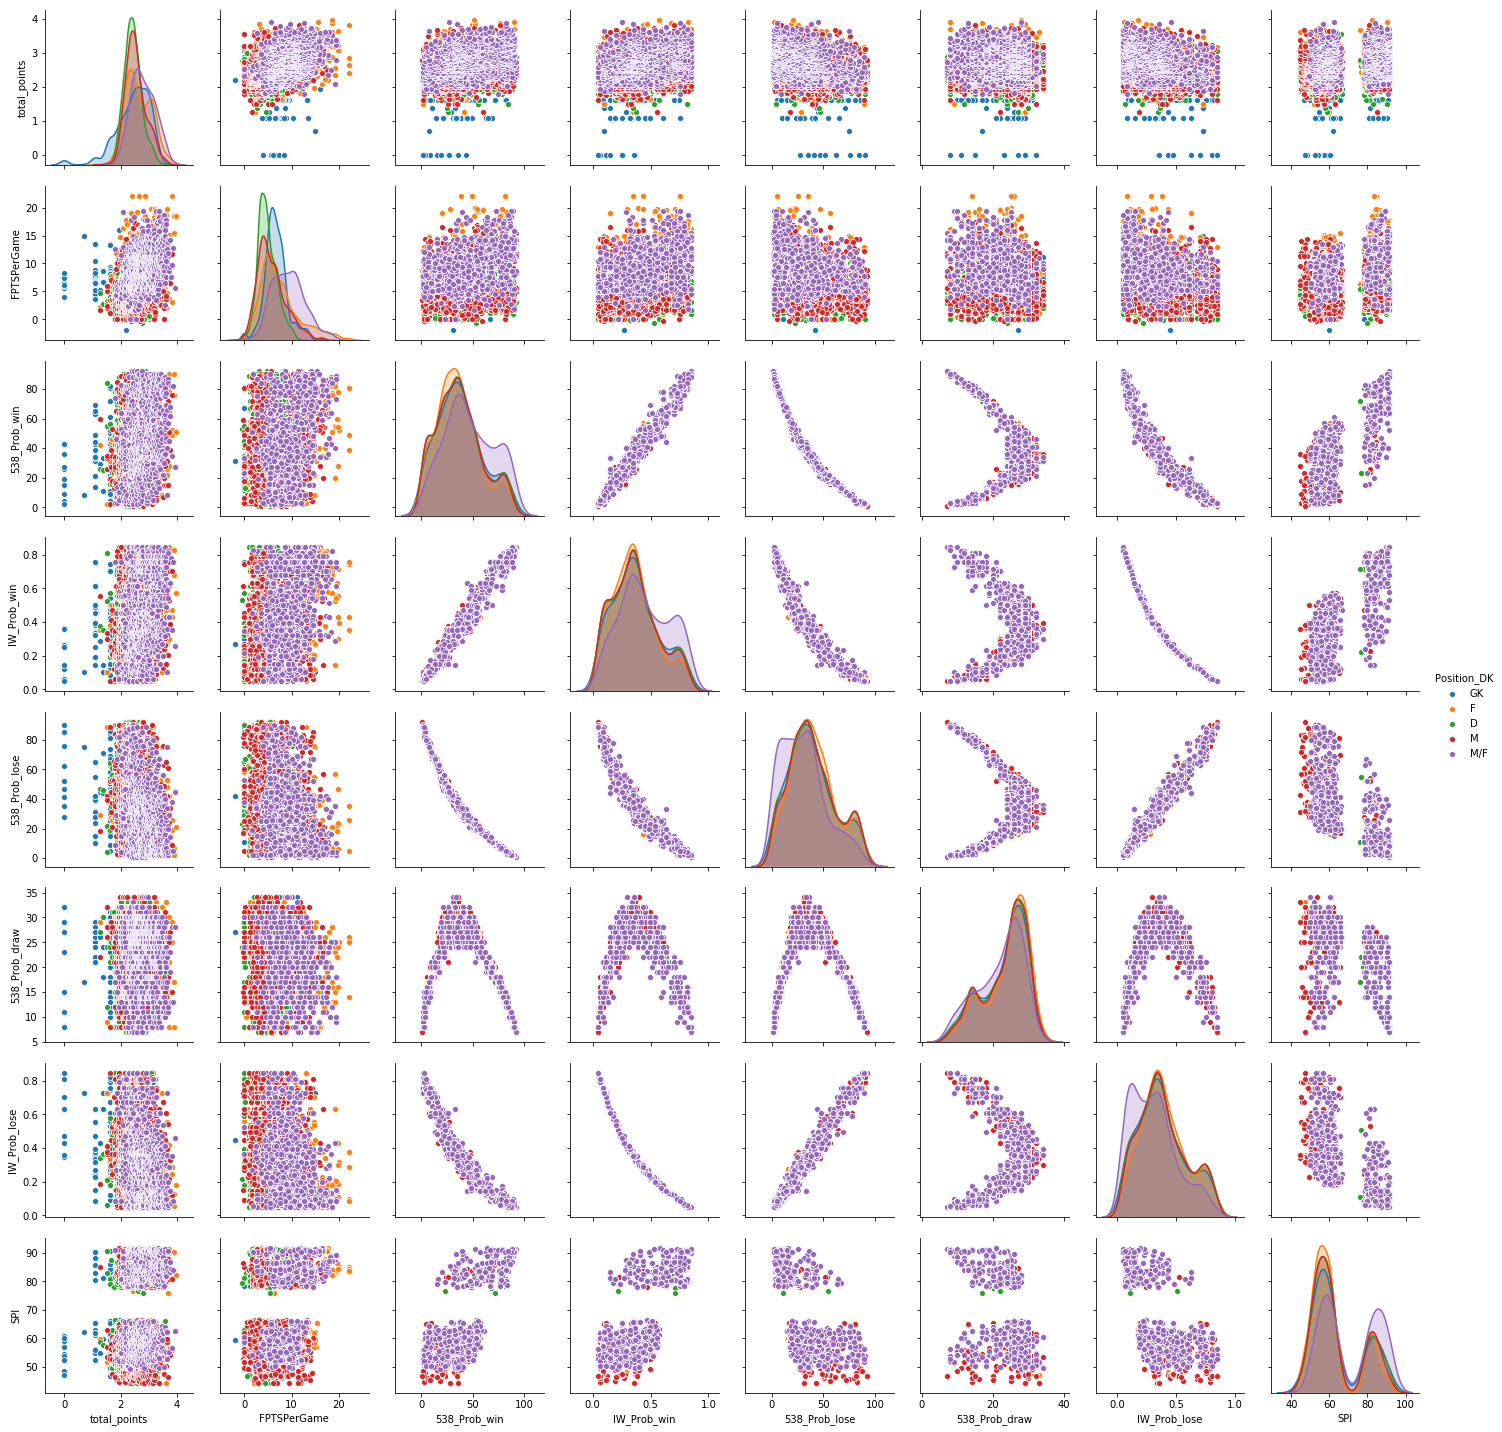

In [107]:
# Player position influence
# data_df_before_encoding.loc[data_df_before_encoding['Position_DK']=='M/F', 'Position_DK'] = 'F'
sns.pairplot(data_df_before_encoding[['total_points', 'FPTSPerGame', 'Position_DK', '538_Prob_win',
       'IW_Prob_win', '538_Prob_lose', '538_Prob_draw',
       'IW_Prob_lose', 'SPI']], hue="Position_DK");


### Marginal distribution and covariance of two variables -- non-linearity?

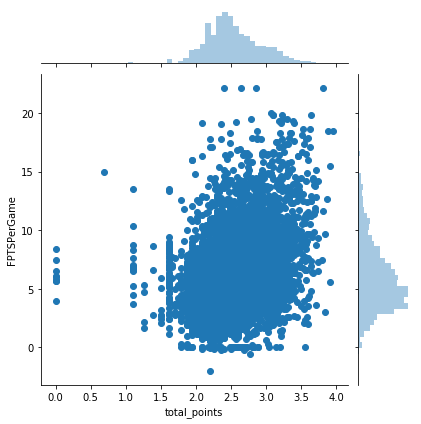

In [63]:
# Marginal distributions
sns.jointplot(x="total_points", y="FPTSPerGame", data=data_df);


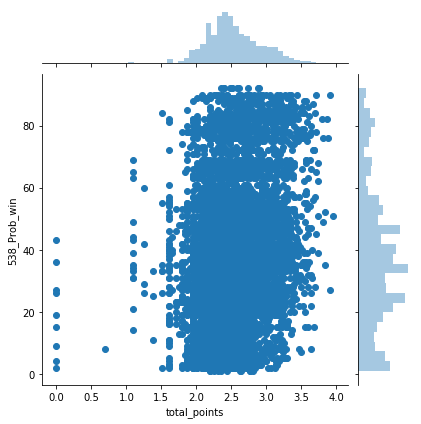

In [71]:
sns.jointplot(x="total_points", y="538_Prob_win", data=data_df);


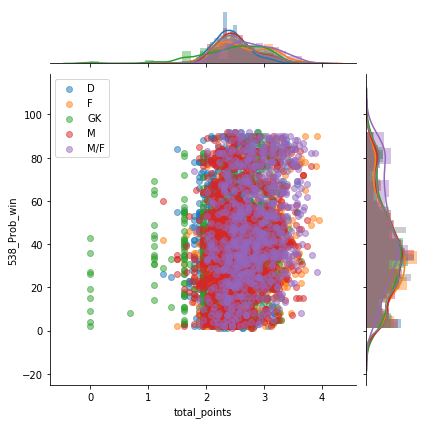

In [36]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )
    # Do also global Hist:
    sns.distplot(
        df[col_x].values,
        ax=g.ax_marg_x,
        color='grey'
    )
    sns.distplot(
        df[col_y].values.ravel(),
        ax=g.ax_marg_y,
        color='grey',
        vertical=True
    )
    plt.legend(legends)
    # credits: ntg on https://stackoverflow.com/questions/35920885/how-to-overlay-a-seaborn-jointplot-with-a-marginal-distribution-histogram-fr/55165689#55165689
multivariateGrid('total_points', '538_Prob_win', 'Position_DK', df=data_df_before_encoding)


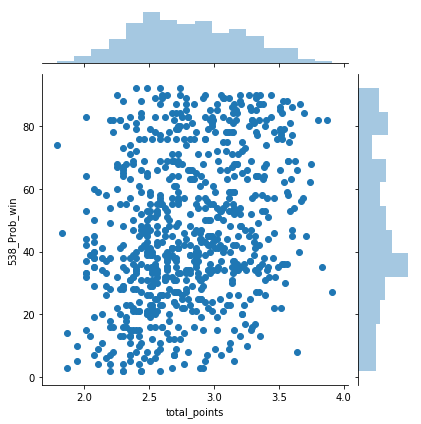

In [75]:
sns.jointplot(x="total_points", y="538_Prob_win", data=data_df[data_df['Position_DK_M/F']==True]);

In [81]:
data_df_all_features = data_df.copy()
data_df_all_features.shape

(6568, 146)

In [100]:
# Drop features with low corrcoef/ irrelevant meanings
data_df_selected_features = data_df.copy()
Reflist = [i for i in data_df.columns if i[:5] in 'Refer']
form_list = [i for i in data_df.columns if i[:5] in 'form_']
data_df_selected_features.drop(home_odds + draw_odds + away_odds + Reflist + form_list + win_odds + draw_odds_new + lose_odds + ['BbOU'], axis=1, inplace=True)
print('dropped', data_df.shape[1]- data_df_selected_features.shape[1], ' features')

dropped 98  features


In [112]:
# Standarize dataset
data_df_standard = data_df_selected_features[['game_date', 'total_points']]
cols = list(data_df_selected_features)
cols.remove('game_date')
cols.remove('total_points')
data_df_to_standard = data_df_selected_features[cols]
data_df_to_standard=(data_df_to_standard-data_df_to_standard.min())/(data_df_to_standard.max()-data_df_to_standard.min())
data_df_standard = pd.concat([data_df_standard, data_df_to_standard], axis=1)


## Modelling

In [114]:
# Separate training and testing (validating)
last_day_training = '2018-02-28'
train_df = data_df_standard[data_df_standard['game_date'] <= last_day_training]
train_y = train_df['total_points']
train_df = train_df.drop(columns=['total_points'])
test_df = data_df_standard[data_df_standard['game_date'] > last_day_training]
test_y = test_df['total_points']
test_df = test_df.drop(columns=['total_points'])

# keep game_date in a seperate df with player name
game_date_player_name_DK_df = pd.concat([data_df_standard['game_date'], player_name_DK_salary_df], axis =1)

# drop variable: game_date -- not a time-series analysis model
train_df = train_df.drop(columns=['game_date'])
test_df = test_df.drop(columns=['game_date'])

print('training data size', train_df.shape, 'testing data size', test_df.shape)


training data size (4410, 46) testing data size (2158, 46)


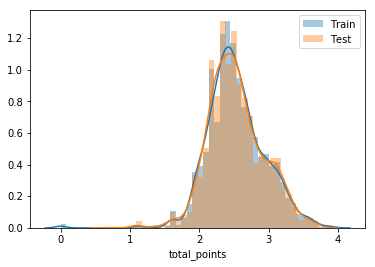

In [211]:
sns.distplot(train_y, label = 'Train')
sns.distplot(test_y, label= 'Test')
plt.legend();

In [137]:
# Five-fold cross validation  -- regression with one variable
def r2_cv_FPTSPerGame(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=0)
    cv_results = cross_validate(model, train_df['FPTSPerGame'].values.reshape(-1, 1), train_y, scoring="r2", cv=kf)
    return (cv_results)

In [115]:
# Five-fold cross validation
def r2_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=0)
    cv_results = cross_validate(model, train_df.values, train_y, scoring="neg_mean_absolute_error", cv=kf, return_estimator=True)
    return (cv_results)

In [116]:
# Cross validation with customized scores
from sklearn.metrics import fbeta_score, make_scorer
def my_custom_loss_func(y_true, y_pred):
    y_true = np.expm1(y_true) # reverse the log transformation
    y_pred = np.expm1(y_pred)
    y_mean = np.mean(y_true)
    SSres = sum((y_pred-y_true)**2)
    SStot = sum((y_true-y_mean)**2)
    my_R2 = 1-SSres/SStot
    mse = np.mean((y_pred-y_true)**2)
    mae = np.mean(np.abs(y_pred-y_true))
    return mae
my_score = make_scorer(my_custom_loss_func, greater_is_better=False)
def custome_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=0)
    cv_results = cross_validate(model, train_df.values, train_y, scoring=my_score, cv=kf)
    return (cv_results)

### Linear Regression

In [139]:
# linear regression with one variable
linear = LinearRegression()
scores = r2_cv_FPTSPerGame(linear)
print("Linear regression with only historical points per game training score: {:.4f} ({:.4f})".format(scores['train_score'].mean(), scores['train_score'].std()))
print("Linear regression CV testing score: {:.4f} ({:.4f})".format(scores['test_score'].mean(), scores['test_score'].std()))

Linear regression with only historical points per game training score: 0.1304 (0.0074)
Linear regression CV testing score: 0.1282 (0.0270)


In [117]:
# Multi-linear regression
linear = LinearRegression()
scores = r2_cv(linear)
print("Multi-Linear regression training R2: {:.4f} ({:.4f})".format(-scores['train_score'].mean(), scores['train_score'].std()))
print("Multi-Linear regression CV testing R2: {:.4f} ({:.4f})".format(-scores['test_score'].mean(), scores['test_score'].std()))

Multi-Linear regression training R2: 0.2811 (0.0033)
Multi-Linear regression CV testing R2: 0.2850 (0.0128)


In [118]:
# Multi-linear regression
linear = LinearRegression()
scores = custome_cv(linear)
print("Multi-Linear regression training MAE: {:.4f} ({:.4f})".format(-scores['train_score'].mean(), scores['train_score'].std()))
print("Multi-Linear regression CV testing MAE: {:.4f} ({:.4f})".format(-scores['test_score'].mean(), scores['test_score'].std()))

Multi-Linear regression training MAE: 3.8549 (0.0542)
Multi-Linear regression CV testing MAE: 3.9049 (0.2163)


Multi-Linear regression CV testing MAE: 3.9049 


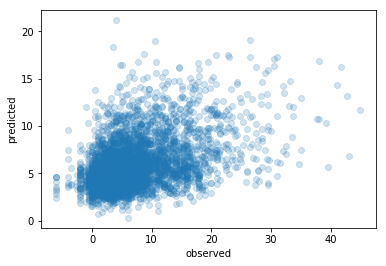

In [119]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(LinearRegression(), train_df.values, train_y, cv=KFold(5, shuffle=True, random_state=0))
plt.scatter(np.expm1(train_y)+min_points_in_original_db, np.expm1(y_pred)+min_points_in_original_db, alpha=0.2)
plt.xlabel('observed') 
plt.ylabel('predicted')
print("Multi-Linear regression CV testing MAE: {:.4f} ".format(my_custom_loss_func(train_y, y_pred)))


### LASSO  Regression

In [120]:
# LASSO  Regression, (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1, L1 regularization
    # you might end up with fewer features included in the model than you started with
    # It is generally used when we have more number of features, because it automatically does feature selection.
lasso = make_pipeline(Lasso(alpha =0.005, random_state=0, max_iter=10000))
scores = custome_cv(lasso)
print("Lasso training score: {:.4f} ({:.4f})".format(-scores['train_score'].mean(), scores['train_score'].std()))
print("Lasso regression CV testing score: {:.4f} ({:.4f})".format(-scores['test_score'].mean(), scores['test_score'].std()))

Lasso training score: 3.9042 (0.0551)
Lasso regression CV testing score: 3.9179 (0.2156)


### Elastic Net Regression

In [121]:
# Elastic Net Regression, combine LASSO and Ridge
    # 1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
ENet = make_pipeline(ElasticNet(alpha=0.005, l1_ratio=.7, random_state=0, max_iter=10000))
scores = custome_cv(ENet)
print("ElasticNet training score: {:.4f} ({:.4f})".format(-scores['train_score'].mean(), scores['train_score'].std()))
print("ElasticNet regression CV testing score: {:.4f} ({:.4f})".format(-scores['test_score'].mean(), scores['test_score'].std()))

ElasticNet training score: 3.8971 (0.0552)
ElasticNet regression CV testing score: 3.9123 (0.2150)


In [122]:
# Compare coefficients of Multi-linear, Lasso, and ENet
linear = linear.fit(train_df.values, train_y)
lasso = Lasso(alpha =0.005, random_state=0).fit(train_df.values, train_y)
ENet = ElasticNet(alpha=0.005, l1_ratio=0.7, random_state=0).fit(train_df.values, train_y)


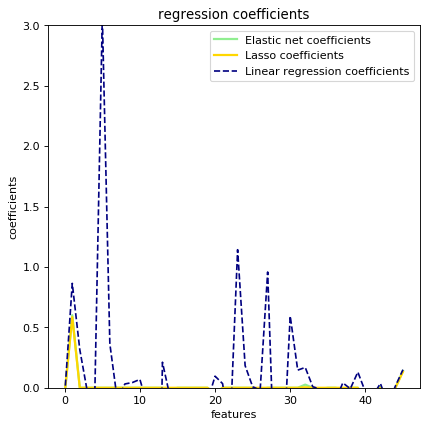

In [126]:
fig=plt.figure(figsize=(6, 6), dpi= 80)
plt.plot(ENet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.ylim([0, 3])
plt.plot(linear.coef_, '--', color='navy', label='Linear regression coefficients')
plt.legend(loc='best')
plt.title('regression coefficients')
plt.xlabel('features')
plt.ylabel('coefficients')
plt.show()

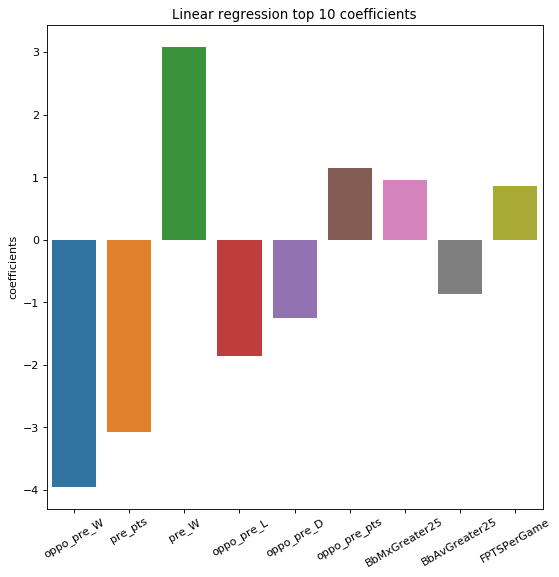

In [127]:
# Bar plot of ENet coefficients
fig=plt.figure(figsize=(8,8), dpi= 80)
a = train_df.columns[np.argsort(abs(linear.coef_))[-9:][::-1]]
b = linear.coef_[np.argsort(abs(linear.coef_))[-9:][::-1]]
g = sns.barplot(x=a, y =b);
g.set_xticklabels(g.get_xticklabels(), rotation=30);
plt.title('Linear regression top 10 coefficients');
plt.ylabel('coefficients');

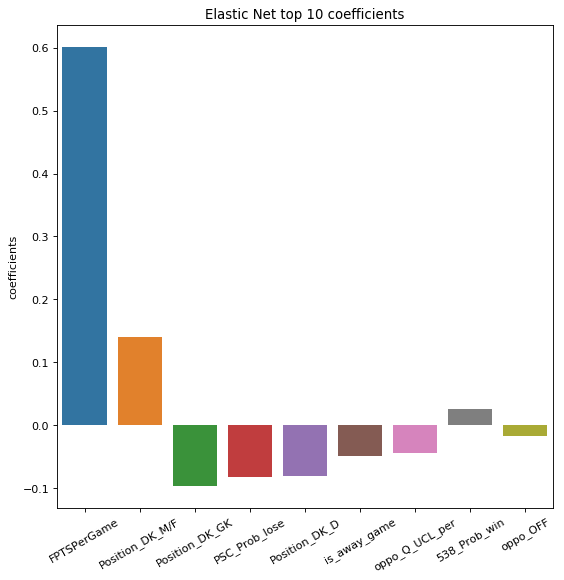

In [124]:
# Bar plot of ENet coefficients
fig=plt.figure(figsize=(8,8), dpi= 80)
a = train_df.columns[np.argsort(abs(ENet.coef_))[-9:][::-1]]
b = ENet.coef_[np.argsort(abs(ENet.coef_))[-9:][::-1]]
g = sns.barplot(x=a, y =b);
g.set_xticklabels(g.get_xticklabels(), rotation=30);
plt.title('Elastic Net top 10 coefficients');
plt.ylabel('coefficients');

### XGBoost: Extreme Gradient Boosting

In [128]:
# XGBoost
model_xgb_no_tune = xgb.XGBRegressor(random_state = 1)
scores = custome_cv(model_xgb_no_tune)
print("XGBoost training score: {:.4f} ({:.4f})".format(-scores['train_score'].mean(), scores['train_score'].std()))
print("XGBoost regression CV testing score: {:.4f} ({:.4f})".format(-scores['test_score'].mean(), scores['test_score'].std()))

XGBoost training score: 3.5264 (0.0533)
XGBoost regression CV testing score: 3.8927 (0.2232)


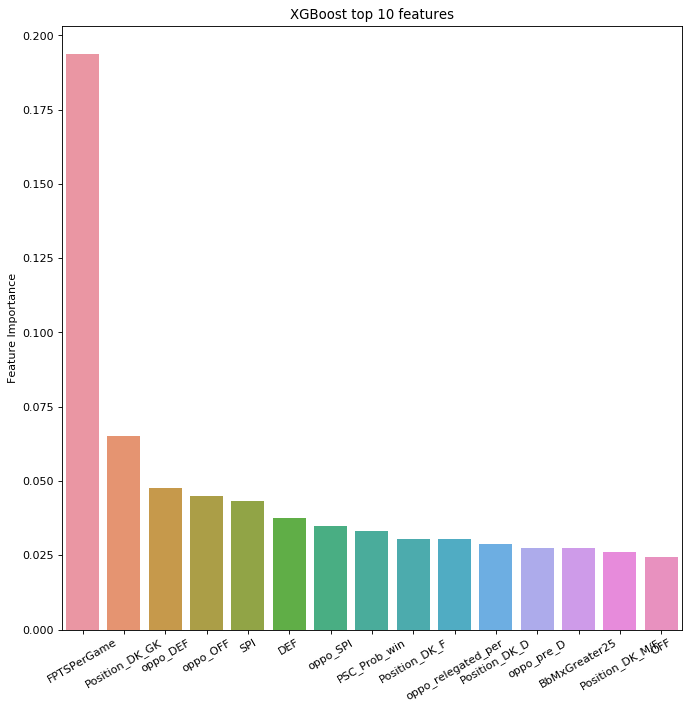

In [129]:
# Important features of XGBoost
model_xgb_no_tune = xgb.XGBRegressor(random_state =1)
model_xgb_no_tune = model_xgb_no_tune.fit(train_df.values, train_y)
model_xgb_no_tune.feature_importances_
fig=plt.figure(figsize=(10,10), dpi= 80)
a = train_df.columns[np.argsort(model_xgb_no_tune.feature_importances_)[-15:][::-1]]
b = model_xgb_no_tune.feature_importances_[np.argsort(model_xgb_no_tune.feature_importances_)[-15:][::-1]]
g = sns.barplot(x=a, y =b);
g.set_xticklabels(g.get_xticklabels(), rotation=30);
plt.title('XGBoost top 10 features');
plt.ylabel('Feature Importance');

#### Fine tune model

In [130]:
# XGBoost fine tune: n_estimators selection
training_scores = []
testing_scores = []
for para_n_estimators in range(30,150,10):
    model_xgb_no_tune = xgb.XGBRegressor(n_estimators=para_n_estimators, random_state =1)
    scores = custome_cv(model_xgb_no_tune)
    print('n_estimators=', para_n_estimators, "Xgboost training score: {:.4f} ({:.4f})".format(-scores['train_score'].mean(), scores['train_score'].std()))
    print('n_estimators=', para_n_estimators, "Xgboost regression CV testing score: {:.4f} ({:.4f})".format(-scores['test_score'].mean(), scores['test_score'].std()))
    training_scores.append(-scores['train_score'].mean())
    testing_scores.append(-scores['test_score'].mean())

n_estimators= 30 Xgboost training score: 3.8167 (0.0493)
n_estimators= 30 Xgboost regression CV testing score: 3.9588 (0.2259)
n_estimators= 40 Xgboost training score: 3.6900 (0.0517)
n_estimators= 40 Xgboost regression CV testing score: 3.8748 (0.2245)
n_estimators= 50 Xgboost training score: 3.6512 (0.0527)
n_estimators= 50 Xgboost regression CV testing score: 3.8758 (0.2239)
n_estimators= 60 Xgboost training score: 3.6222 (0.0523)
n_estimators= 60 Xgboost regression CV testing score: 3.8791 (0.2245)
n_estimators= 70 Xgboost training score: 3.5963 (0.0525)
n_estimators= 70 Xgboost regression CV testing score: 3.8841 (0.2244)
n_estimators= 80 Xgboost training score: 3.5725 (0.0544)
n_estimators= 80 Xgboost regression CV testing score: 3.8859 (0.2230)
n_estimators= 90 Xgboost training score: 3.5476 (0.0529)
n_estimators= 90 Xgboost regression CV testing score: 3.8887 (0.2252)
n_estimators= 100 Xgboost training score: 3.5264 (0.0533)
n_estimators= 100 Xgboost regression CV testing score

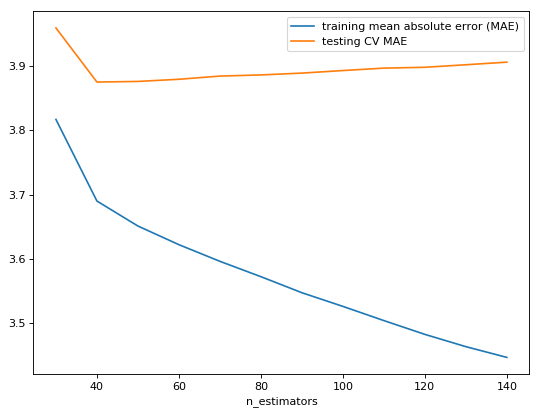

In [131]:
fig=plt.figure(figsize=(8,6), dpi= 80)
sns.lineplot(x=range(30,150,10), y=training_scores, label = 'training mean absolute error (MAE)');
sns.lineplot(x=range(30,150,10), y=testing_scores, label = 'testing CV MAE');
plt.xlabel('n_estimators');

In [132]:
# define a fine tune function
def para_search(model, param_test):
    kf = KFold(5, shuffle=True, random_state=0)
    gsearch = GridSearchCV(estimator = model, param_grid = param_test, scoring = my_score, verbose=1, cv=kf, n_jobs = 10)
    gsearch.fit(train_df.values, train_y)
    print('best score: {:.4f}'.format(-gsearch.best_score_), 'best parameters:', gsearch.best_params_)

In [133]:
# Fine Tune for the best parameters (n_estimator and learning rate)
param_test1 = {
 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
 'n_estimators': range(30, 150, 20)
}
para_search(xgb.XGBRegressor(random_state=1), param_test1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.0s


best score: 3.8758 best parameters: {'learning_rate': 0.1, 'n_estimators': 50}


[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    9.8s finished


In [139]:
# Tune for the best parameters (max_depth and min_child_weight)
param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,12,2)
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=50, random_state=1), param_test1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s


best score: 3.8607 best parameters: {'max_depth': 3, 'min_child_weight': 9}


[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.1s finished


In [140]:
# Fine Tune for the best parameters (max_depth and min_child_weight)
param_test1 = {
 'max_depth': [2, 3, 4],
 'min_child_weight': [8, 9, 10]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=90, random_state=1), param_test1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:    2.1s finished


best score: 3.8653 best parameters: {'max_depth': 3, 'min_child_weight': 10}


In [141]:
# Tune for the best parameters (gamma) # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=50, random_state=1, max_depth=3, min_child_weight=10), param_test1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


best score: 3.8539 best parameters: {'gamma': 0.0}


[Parallel(n_jobs=10)]: Done  25 out of  25 | elapsed:    0.7s finished


In [143]:
# Tune for the best parameters (subsample and colsample_bytree)
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=50, random_state=1, max_depth=3, min_child_weight=5, gamma=0), param_test1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.6s finished


best score: 3.8559 best parameters: {'colsample_bytree': 1.0, 'subsample': 0.8}


In [145]:
# Tune for the best parameters (Regularization Parameters)
param_test1 = {
 'reg_alpha':[0, 1e-5, 1e-3, 0.1, 1, 10, 100]
}
para_search(xgb.XGBRegressor(learning_rate=0.1, n_estimators=50, random_state=1, max_depth=3, min_child_weight=5, subsample=0.8), param_test1)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  35 out of  35 | elapsed:    1.0s finished


best score: 3.8525 best parameters: {'reg_alpha': 0.1}


In [146]:
# Fine tuned XGBoost model
model_xgb_tuned = xgb.XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=3, min_child_weight=5, subsample=0.8, reg_alpha=0.1, random_state=1)
scores = custome_cv(model_xgb_tuned)
print("Tuned XGBoost training score: {:.4f} ({:.4f})".format(-scores['train_score'].mean(), scores['train_score'].std()))
print("XGBoost regression CV testing score: {:.4f} ({:.4f})".format(-scores['test_score'].mean(), scores['test_score'].std()))

Tuned XGBoost training score: 3.6580 (0.0550)
XGBoost regression CV testing score: 3.8525 (0.2137)


## Testing with real player results
#### Pick 8 players (1 GK, 2 Defenders, 2 Midfielders, 2 Forwards, 1 Util) under a total salary cap that gives the highest scores
#### Objective
- Maximize the fantasy scores

#### Constrains:
- Salary Cap
- Position Limit
- Team Limit


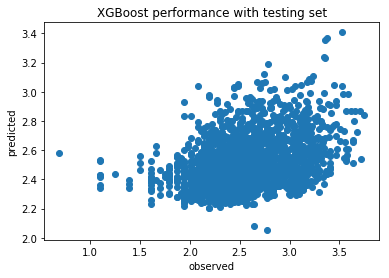

In [194]:
# Training with all the whole training set and make prediction on the testing set
model_xgb_tuned = xgb.XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=3, min_child_weight=5, subsample=0.8, reg_alpha=0.1, random_state=1)
model_xgb_tuned = model_xgb_tuned.fit(train_df, train_y)
test_predicted = model_xgb_tuned.predict(test_df)
fig=plt.figure()
plt.plot(test_y, test_predicted, 'o')
# plt.plot([0, 4], [0, 4])
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('XGBoost performance with testing set')
plt.show()

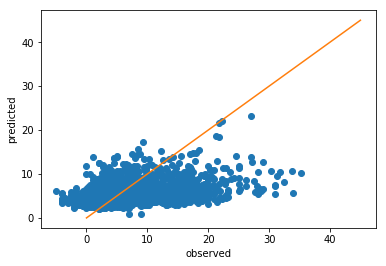

In [195]:
plt.plot(np.expm1(test_y)+min_points_in_original_db, np.expm1(test_predicted)+min_points_in_original_db, 'o')
plt.plot([0, 45], [0, 45])
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [196]:
print('Test set MAE with XGBoost {:.4f}'.format(my_custom_loss_func(test_y, test_predicted)))

Test set MAE with XGBoost 3.8478


In [185]:
# Model with linear regressor
reg = LinearRegression().fit(train_df, train_y)  # lasso, ENet
# train_pred = reg.predict(train_df)
# print('Linear regressor training MAE {:.4f}'.format(my_custom_loss_func(train_pred, train_y)))
test_predicted = reg.predict(test_df)
print('Test set MAE with linear regressor {:.4f}'.format(my_custom_loss_func(test_predicted, test_y)))


Test set MAE with linear regressor 3.8911


In [183]:
# reg = lasso.fit(train_df, train_y)
# train_pred = reg.predict(train_df)
# # print('Linear regressor training MAE {:.4f}'.format(my_custom_loss_func(train_pred, train_y)))
# # test_pred = reg.predict(test_df)
# print('Test set MAE {:.4f}'.format(my_custom_loss_func(test_pred, test_y)))


In [197]:
# concatenate predicted points with player name and game date
game_date_player_name_DK_test_df = game_date_player_name_DK_df[game_date_player_name_DK_df['game_date']>last_day_training]
test_predicted_series = pd.Series(test_predicted, index=test_y.index)
predicted_test_df = pd.concat([test_predicted_series, test_y, game_date_player_name_DK_test_df], axis=1)
predicted_test_df = predicted_test_df.rename(columns={0: 'predicted_pts'})

In [198]:
# Transform back to original points for comparison purpose
predicted_test_df['total_points'] = np.expm1(predicted_test_df['total_points']) + min_points_in_original_db
predicted_test_df['predicted_pts'] = np.expm1(predicted_test_df['predicted_pts']) + min_points_in_original_db

In [199]:
# Load player salary and position info
disk_engine = create_engine('sqlite:///EPL1718_org.db')
player_data_salary_df = pd.read_sql('player_data_extended', disk_engine)
print('df shape of salary DB', player_data_salary_df.shape)
DK_result_df = pd.read_sql('DK_result', disk_engine)
print('df shape of actual DK result DB',DK_result_df.shape)


df shape of salary DB (9582, 148)
df shape of actual DK result DB (182177, 16)


In [200]:
# For DK result for the same day with multiple competitions (diff in participants) -- keep the one with the most participants
for game_date in DK_result_df['Game_date'].unique():
    if len(DK_result_df[DK_result_df['Game_date']==game_date]['total_participants'].unique()) != 1:
#         print(game_date,'with more than 1 competitions recorded')
#         print('keep the competition with ', max(DK_result_df[DK_result_df['Game_date']==game_date]['total_participants'].unique()), 'participants')
#         print('dropped', sum(DK_result_df.loc[DK_result_df['Game_date']==game_date, 'total_participants']!=max(DK_result_df[DK_result_df['Game_date']==game_date]['total_participants'].unique())), 'player records')
        DK_result_df = DK_result_df.drop(DK_result_df[(DK_result_df['Game_date']==game_date) &
            (DK_result_df['total_participants']!=max(DK_result_df[DK_result_df['Game_date']==game_date]['total_participants'].unique()))].index)


In [201]:
# fill salary and position info for testing df
for label_in_predicted_test_df in predicted_test_df.index:
#     player_data_salary_df[ (player_data_salary_df['player_name_DK_salary'] == predicted_test_df.loc[label_in_predicted_test_df, 'player_name_DK_salary'])
#                           & (player_data_salary_df['game_date'] == predicted_test_df.loc[label_in_predicted_test_df, 'game_date'])
#                             ] ['DK_salary']
    predicted_test_df.loc[label_in_predicted_test_df, 'DK_salary'] = \
                player_data_salary_df[ (player_data_salary_df['player_name_DK_salary'] == predicted_test_df.loc[label_in_predicted_test_df, 'player_name_DK_salary'])
                          & (player_data_salary_df['game_date'] == predicted_test_df.loc[label_in_predicted_test_df, 'game_date'])
                            ] ['DK_salary'].values[0]
    predicted_test_df.loc[label_in_predicted_test_df, 'Position_DK'] = \
                player_data_salary_df[ (player_data_salary_df['player_name_DK_salary'] == predicted_test_df.loc[label_in_predicted_test_df, 'player_name_DK_salary'])
                          & (player_data_salary_df['game_date'] == predicted_test_df.loc[label_in_predicted_test_df, 'game_date'])
                            ] ['Position_DK'].values[0]
    predicted_test_df.loc[label_in_predicted_test_df, 'Team_name'] = \
                player_data_salary_df[ (player_data_salary_df['player_name_DK_salary'] == predicted_test_df.loc[label_in_predicted_test_df, 'player_name_DK_salary'])
                          & (player_data_salary_df['game_date'] == predicted_test_df.loc[label_in_predicted_test_df, 'game_date'])
                            ] ['team_name_full_roto'].values[0]
    predicted_test_df.loc[label_in_predicted_test_df, 'Team_name_oppo'] = \
                player_data_salary_df[ (player_data_salary_df['player_name_DK_salary'] == predicted_test_df.loc[label_in_predicted_test_df, 'player_name_DK_salary'])
                          & (player_data_salary_df['game_date'] == predicted_test_df.loc[label_in_predicted_test_df, 'game_date'])
                            ] ['oppo_team_name_full'].values[0]
    if player_data_salary_df[ (player_data_salary_df['player_name_DK_salary'] == predicted_test_df.loc[label_in_predicted_test_df, 'player_name_DK_salary'])
                          & (player_data_salary_df['game_date'] == predicted_test_df.loc[label_in_predicted_test_df, 'game_date'])
                            ] ['is_away_game'].values[0] == b'\x00':
        predicted_test_df.loc[label_in_predicted_test_df, 'Matchup'] = predicted_test_df.loc[label_in_predicted_test_df, 'Team_name'] + '@' + predicted_test_df.loc[label_in_predicted_test_df, 'Team_name_oppo']
    else:
        predicted_test_df.loc[label_in_predicted_test_df, 'Matchup'] = predicted_test_df.loc[label_in_predicted_test_df, 'Team_name_oppo'] + '@' + predicted_test_df.loc[label_in_predicted_test_df, 'Team_name']

In [202]:
from draftfast import rules
from draftfast.optimize import run, run_multi
from draftfast.orm import Player
from draftfast.csv_parse import salary_download

In [203]:
ranking_percentile = []
simulated_cost = []
simulated_earn = []
for game_date in np.sort(predicted_test_df['game_date'].unique()):
    if predicted_test_df[(predicted_test_df['game_date']==game_date) & ~predicted_test_df['DK_salary'].isnull()].shape[0]>40:
        # withdraw days with no salary file available
#         print(predicted_test_df[(predicted_test_df['game_date']==game_date) & ~predicted_test_df['DK_salary'].isnull()].shape[0])
        print(str(game_date)[:10])
        
        curr_pred_df = predicted_test_df[(predicted_test_df['game_date']==game_date) & ~predicted_test_df['DK_salary'].isnull()]
        curr_pred_df.loc[curr_pred_df['Position_DK']=='M/F', 'Position_DK'] = 'F'
        player_pool = []
        for itr, row in curr_pred_df.iterrows():
            player_pool.append(Player(name=row['player_name_DK_salary'], cost=row['DK_salary'], proj=row['predicted_pts'], \
                          pos=row['Position_DK'], team=row['Team_name'], matchup=row['Matchup']))

        roster = run_multi(
            rule_set=rules.DK_SOCCER_RULE_SET,
            player_pool=player_pool,
            verbose=False,
            iterations=1
        )
        best_pred_cost = sum([player.cost for player in roster[0][0].sorted_players()])
        best_pred_proj = sum([player.proj for player in roster[0][0].sorted_players()])
        best_pred_proj_actual = sum([curr_pred_df[curr_pred_df['player_name_DK_salary'] == player.name]['total_points'].iloc[0] \
                                     for player in roster[0][0].sorted_players()])
        DK_result_max_series = DK_result_df[DK_result_df['Game_date'] == pd.to_datetime(game_date).strftime('%Y%m%d')].sort_values(by='DK_points', ascending=False).iloc[0]
        DK_result_diff_series = abs(DK_result_df[DK_result_df['Game_date'] == pd.to_datetime(game_date).strftime('%Y%m%d')]['DK_points'] - best_pred_proj_actual)
        DK_result_closest_series = DK_result_df.loc[DK_result_diff_series.sort_values(ascending=True).index[0]]
        
        ranking_percentile.append(DK_result_closest_series['ranking']/DK_result_closest_series['total_participants'])
        simulated_cost.append(DK_result_closest_series['damage'])
        simulated_earn.append(DK_result_closest_series['revenue'])

        print("Selected lineup cost: {:.0f}, projected score: {:.1f}, actual score: {:.1f}, best score among players: {:.1f}, percentile: {:.0f}" \
              .format(best_pred_cost, best_pred_proj, best_pred_proj_actual, DK_result_max_series['DK_points']\
                     ,DK_result_closest_series['ranking']/DK_result_closest_series['total_participants']*100))
        print(' ')

2018-03-03
Selected lineup cost: 50000, projected score: 80.3, actual score: 90.0, best score among players: 143.5, percentile: 36
 
2018-03-04


C:\Users\qdlzh\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Selected lineup cost: 49700, projected score: 64.6, actual score: 63.0, best score among players: 94.5, percentile: 38
 
2018-03-10
Selected lineup cost: 49900, projected score: 69.4, actual score: 77.8, best score among players: 132.5, percentile: 35
 
2018-03-11
Selected lineup cost: 49100, projected score: 60.4, actual score: 141.7, best score among players: 167.8, percentile: 3
 
2018-03-17
Selected lineup cost: 50000, projected score: 66.5, actual score: 82.5, best score among players: 162.0, percentile: 75
 
2018-03-31
Selected lineup cost: 50000, projected score: 74.7, actual score: 96.8, best score among players: 144.0, percentile: 25
 
2018-04-01
Selected lineup cost: 49500, projected score: 69.3, actual score: 61.0, best score among players: 131.8, percentile: 89
 
2018-04-07
Selected lineup cost: 50000, projected score: 69.6, actual score: 71.8, best score among players: 131.8, percentile: 44
 
2018-04-14
Selected lineup cost: 50000, projected score: 71.9, actual score: 87.0

In [204]:
print('Simulated drafts beat {:.0f}% participants in the actual competitions'.format(100-np.mean(ranking_percentile)*100))
print('Simulated total cost: {:.1f}, simulated total revenue: {:.1f}'.format(sum(simulated_cost), sum(simulated_earn)))


Simulated drafts beat 54% participants in the actual competitions
Simulated total cost: 85.0, simulated total revenue: 43.0


## Conclusions: 
## Player performance is a highly stochastic process. However, the tested machine learning methods do offer some prediction power (~ average player) 
## Yet, it is still far away from profitable.
<img style="float: left;" src="https://i.ibb.co/0thHqKd/DK-User-stats.png" width="500px"/>
data from: Draftkings.com

<br/> <br/>

## Future Directions <br/>
### Data Collection: 
#### More data: player recent status (NLP sentiment analysis on player's social media etc.)
#### More features: game importance to teams; team/player trends (e.g. winning/losing streaks) <br/> <br/>
### Modelling:
#### Consider creative error function -- cost more for missing players' high performance -- weighted MSE/MAE
#### Player role specific models
#### Time Series Analysis to pick up trends
<br/> <br/>
<br/> <br/>
<br/> <br/>

# Todo:
- For dummy encoding, did you look at the distribution of each variable, do you need to consider the distribution?
- Marginal effects plots among variables
- what are the new featured variables difference in linear models and XGBoost? are they representing some non-linearity 
- Is it appropriate to use the same standarization process with training and testing set? Are they under the same distribution?